## 0. Execute Once - Load Dataset From Kaggle

### Set up the notebook
- **Create new API Token** under Kaggle profile
- Upload downloaded kaggle.json file to the designated folder on Google Drive

In [ ]:
# ! pip install kaggle

In [ ]:
# mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Config Kaggle

In [ ]:
# set the Kaggle configuration path to kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/deep_learning"

In [ ]:
# change the working directory
%cd /content/gdrive/MyDrive/deep_learning/data

/content/gdrive/MyDrive/deep_learning/data


### Download Dataset

Go to Kaggle datasets Dashboard and click on `Copy API Command`.

Note: The dataset is downloaded as a zip file. We use a keyword `--unzip` used to instantly unzip the file after download and delete the zip file.

In [ ]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources --force

100% 1.37G/1.37G [01:01<00:00, 26.0MB/s]
100% 1.37G/1.37G [01:01<00:00, 23.9MB/s]


In [ ]:
!rm /content/gdrive/MyDrive/deep_learning/data/train -r
!rm /content/gdrive/MyDrive/deep_learning/data/valid -r

rm: cannot remove '/content/gdrive/MyDrive/deep_learning/data/train': No such file or directory
rm: cannot remove '/content/gdrive/MyDrive/deep_learning/data/valid': No such file or directory


In [ ]:
# unzip using python library
import zipfile

with zipfile.ZipFile('tomato-disease-multiple-sources.zip','r') as zip_ref:
  zip_ref.extractall('./')

In [ ]:
# check the file using 'ls' command
%ls

tomato-disease-multiple-sources.zip  train/  valid/


In [ ]:
# audit: make sure we have 25,851 images in train and 6,684 images in valid
train_len, test_len = 0, 0
TRAIN_DATA_PATH_GDRIVE = '/content/gdrive/MyDrive/deep_learning/data/train'
VALID_DATA_PATH_GDRIVE = '/content/gdrive/MyDrive/deep_learning/data/valid'

for f in os.listdir(TRAIN_DATA_PATH_GDRIVE):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH_GDRIVE, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH_GDRIVE, f)))

print("{} images in training set".format(train_len))
print("{} images in test set.".format(test_len))
assert train_len == 25851, "Missing images in training set. It should include 25,851 images"
assert test_len == 6684, "Missing images in valid set. It should include 6,684 images"

25851 images in training set
6684 images in test set.


## 1. Set-up

### Import Libraries

In [ ]:
# data manipulation
import numpy as np
import pandas as pd

# image processing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# pre-trained model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

# sklearn utility functions
from sklearn.metrics import confusion_matrix, classification_report

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr
import datetime

# set up random seed
import random
seed = 24
tf.random.set_seed(seed)

# customize printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 200)

### Copy Raw Data Files From Google Drive To Local Colab Session to Avoid Disrupt Connections

In [ ]:
# # mount Google Drive to Google Colab notebook
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# create folder in local colab session
#!rm /content/data -r
!mkdir /content/data

In [ ]:
!cp -r /content/gdrive/MyDrive/deep_learning/data/train /content/data
!cp -r /content/gdrive/MyDrive/deep_learning/data/valid /content/data

### Environmental Variables

In [ ]:
# environmental variables
TRAIN_DATA_PATH = '/content/data/train'
VALID_DATA_PATH = '/content/data/valid'

CLASSES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASSES)
TIMESTAMP = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# audit - add timestamp to saved file to avoid overwirting
print(TIMESTAMP)

20230321-040550


In [ ]:
# audit - check number of classes
print(CLASSES)
print('{} classes of images'.format(NUM_CLASSES))

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
11 classes of images


In [ ]:
# audit - check number of raw images
train_len, test_len = 0, 0

for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))

print(train_len); print(test_len)
assert train_len == 25851, "Missing images in training set. It should include 25,851 images"
assert test_len == 6684, "Missing images in valid set. It should include 6,684 images"

25851
6684


### Define utility functions
- training history plot
- confusion matrix

In [ ]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

In [ ]:
# source: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf, group_names=None,categories='auto', count=True,percent=False,cbar=True, 
                          xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,
                          cmap='Blues',title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
def error_analysis(model, test_data, class_names):
  plt.figure(figsize=(18,12))
  for image_batch,label_batch in test_data.take(4):
      predictions = model.predict(image_batch)
      predictions = np.argmax(predictions, axis=-1)
      for i in range(0,len(predictions) if len(predictions)<12 else 12):
          plt.subplot(3,4,i+1)
          plt.imshow(image_batch[i].numpy().astype("uint32"))
          true_class = class_names[np.argmax(label_batch[i])]
          predict_class = class_names[predictions[i]]
          title = f"""True: {true_class}\n Predict: {predict_class}"""
          plt.title(title, color='g' if true_class==predict_class else 'r')
          plt.axis("off")

## 2. Data Cleaning

TensorFlow has some strictness when dealing with image formats. Some times your data set may even run well with, for instance Torch but will generate a format error with Tf. Nonetheless, it is best practice to always carryout preprocessing on the images to ensure a robust, safe and standard model.

*Reference*:
- [Unknown image file format. One of JPEG, PNG, GIF, BMP required](https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required)

In [ ]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images

In [ ]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [ ]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [ ]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
-------------------- check training set image quality. --------------------
/content/data/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg is not an image
/content/data/train/Early_blight/EB_(976).jpg is not an image
/content/data/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg is not an image
/content/data/train/Leaf_Mold/BM_(7).jpg is not an image
/content/data/train/Leaf_Mold/BM_(98).jpg is not an image
/content/data/train/Leaf_Mold/607-155-1.jpg is not an image
/content/data/train/Leaf_Mold/BM_(6).jpg is not an image
/content/data/train/Leaf_Mold/BM_(975).jpg is not an image
/content/data/train/Leaf_Mold/BM_(976).jpg is not an image
/content/data/train/Septoria_leaf_spot/SS_ (51).jpg is not an image
/content/data/train/healthy/edible-tomato-leaves.jpg is a webp, not accepted by TensorFlow
/content/data/train/healthy/branch-tomato-leaves-iaolsted-on-260nw-1025727106.jpg is not an i

In [ ]:
# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
-------------------- check training set image quality. --------------------


Bacterial_spot         : 100%|███████████████████████████████████████| 2826/2826 [00:00<00:00, 60531.22file/s]


/content/data/train/Bacterial_spot/bacterialspotontomatoXant.JPG


Early_blight           : 100%|███████████████████████████████████████| 2455/2455 [00:00<00:00, 61162.88file/s]


/content/data/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg


healthy                : 100%|███████████████████████████████████████| 3051/3051 [00:00<00:00, 48714.54file/s]


/content/data/train/healthy/edible-tomato-leaves.jpg
/content/data/train/healthy/A-Healthy-leaves-of-tomato-plants-and-B-Leaves-of-tomato-plants-inoculated-with.png


powdery_mildew         : 100%|███████████████████████████████████████| 1004/1004 [00:00<00:00, 61066.45file/s]


-------------------- check test and validation set image quality. --------------------


Leaf_Mold              : 100%|█████████████████████████████████████████| 739/739 [00:00<00:00, 51895.97file/s]


/content/data/valid/Leaf_Mold/BM_(9).jpg


healthy                : 100%|█████████████████████████████████████████| 806/806 [00:00<00:00, 57265.46file/s]


/content/data/valid/healthy/HL_(336).png
/content/data/valid/healthy/2013-08-20-05.jpg


powdery_mildew         : 100%|█████████████████████████████████████████| 252/252 [00:00<00:00, 52954.14file/s]


In [ ]:
# check image quality 3
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(VALID_DATA_PATH)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 639884.70file/s]


-------------------- check test and validation set image quality. --------------------


healthy                :  57%|████████████████████████▌                  | 461/806 [00:00<00:00, 730.36file/s]

defective image file:  /content/data/valid/healthy/HL_(336).png


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 466033.78file/s]


In [ ]:
move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))

{'/content/data/train/Bacterial_spot/bacterialspotontomatoXant.JPG',
 PosixPath('/content/data/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg'),
 PosixPath('/content/data/train/Early_blight/EB_(976).jpg'),
 PosixPath('/content/data/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg'),
 '/content/data/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg',
 PosixPath('/content/data/train/Leaf_Mold/607-155-1.jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(6).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(7).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(975).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(976).jpg'),
 PosixPath('/content/data/train/Leaf_Mold/BM_(98).jpg'),
 PosixPath('/content/data/train/Septoria_leaf_spot/SS_ (51).jpg'),
 '/content/data/train/healthy/A-Healthy-leaves-of-tomato-plants-and-B-Leaves-of-tomato-plants-inoculated-with.png',
 PosixPath('/content/data/train/healthy/branch-tomato-leaves-iaolsted-on-26

Move 25 images with bad quality.


In [ ]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25835
6677


In [ ]:
del image_quality_check, image_quality_check2, image_quality_check3, bad_images_train, bad_images_val_test, bad_images_train2, bad_images_val_test2, bad_images_train3, bad_images_val_test3
gc.collect()

0

#### Load Data

We will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk. 
  - `image_dataset_from_directory` returns a `tf.data.Dataset` object, a tuple `(images, labels)`, where `images` has shape  is `(batch_size, image_size[0], image_size[1], num_channels)`. 
  - supported image formats: jpeg, png, bmp, gif

*Reference*:
- [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 299, 299   # default image size for Xception is 299x299
BATCH_SIZE = 32
LABEL_MODE = 'categorical'  # labels: one-hot encoded, a float32 tensor of shape (batch_size, num_classes). loss: categorical_crossentropy
COLOR_MODE = 'rgb'
VALID_TEST_RATIO = 0.5
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# training set - expect 25,851 (25,835) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        labels='inferred',
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25835 files belonging to 11 classes.


In [ ]:
# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        directory=VALID_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        labels='inferred',
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed,
        validation_split = VALID_TEST_RATIO, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [ ]:
# Save class names and mappings between label_id vs class
CLASS_NAMES = test_ds.class_names
CLASS_NAMES_TF = {k: v for v, k in enumerate(CLASS_NAMES)}
print(CLASS_NAMES)
print(CLASS_NAMES_TF)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


In [ ]:
# audit - make sure validation and test sets are approximately follow same distribution
assert((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test does not match'

In [ ]:
# check number of batches
print('train dataset size: ' + str(train_ds.cardinality().numpy()))
print('valid dataset size: ' + str(valid_ds.cardinality().numpy()))
print('test dataset size: ' + str(test_ds.cardinality().numpy()))

train dataset size: 808
valid dataset size: 105
test dataset size: 105


## 3. Data Preprocessing

#### Data Augmentation

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` during training (not `Model.evaluate` or `Model.predict`).

1) Using Keras preprocessing layers, such as`tf.keras.layers.RandomCrop`,`tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomTranslation`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomZoom`, `tf.keras.layers.RandomHeight`, `tf.keras.layers.RandomWidth`, `tf.keras.layers.RandomContrast`

2) Using `tf.image` methods, such as `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop`, and `tf.image.stateless_random*`.

*Reference*:
- [keras documentation: data_augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
- [image classification](https://www.tensorflow.org/tutorials/images/classification#setup)
- [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)

In [ ]:
data_augmentation = keras.Sequential(
    [
      # make model more tolerate to variations in position 
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), seed=seed),     
      layers.RandomRotation(0.1, seed = seed),  # randomly rotates images during training
      layers.RandomZoom(0.1, seed = seed),      # randomly flips images during training
      layers.RandomTranslation(height_factor=0.15, width_factor=0.15, seed = seed),  # random geometric translation
     
      # make model more tolerate to different lighting conditions 
      layers.RandomContrast(0.15, seed = seed),       #randomly adjusts contrast during training
      layers.RandomBrightness(factor=0.2, seed=seed)  #randomly increase/decrease brightness during training
    ], name = 'data_augmentation'
)

In [ ]:
# # Visualize a few augmented examples by applying data augmentation to the same image several times:
# plt.figure(figsize=(10, 20))
# for images, _ in train_ds.take(1):
#   for i in range(20):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(5, 4, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

#### Data Preprocessing for Pre-trained Model

If you are using any pretrained model, you need to **use the same preprocessing that was used for training that model**

Note: each Keras Application expects a specific kind of input preprocessing. For InceptionV3, call `tf.keras.applications.inception_v3.preprocess_input` on your inputs before passing them to the model. `inception_v3.preprocess_input` will **scale input pixels between -1 and 1**.


*Reference*:
- [working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)
- [apply the preprocessing layers to the datasets](https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets)
- [how to apply `preprocessing_input` to `tf.data.Dataset`](https://stackoverflow.com/questions/74818306/issues-with-using-tensorflows-preprocessing-function-for-inceptionv3)
- [data preprocessing for Xception](https://keras.io/api/applications/xception/)
-------------
- The default input image size for this model is 299x299.
- scale input pixels between -1 and 1

In [ ]:
augment = True

if augment:
  train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

## 4. Pre-trained Model as Feature Extractor

### Pre-trained models with BatchNorm

Assume you are building a Computer Vision model but you don’t have enough data, so you decide to use one of the pre-trained CNNs of Keras and fine-tune it. <font color='red'>**Unfortunately, by doing so you get no guarantees that the mean and variance of your new dataset inside the BN layers will be similar to the ones of the original dataset. Remember that at the moment, during training your network will always use the mini-batch statistics either the BN layer is frozen or not; also during inference you will use the previously learned statistics of the frozen BN layers (ie. imagenet).**</font> As a result, if you fine-tune the top layers, their weights will be adjusted to the mean/variance of the new dataset. Nevertheless, during inference they will receive data which are scaled differently because the mean/variance of the original dataset will be used.

Solution: `x=base_model(inputs, training=True)`. Even thouh I have a frozen pre-trined network, I stil need to set BatchNorm training - True. 

*Reference*:
- [stackoverflow - massive overfitting duruing resnet50 transfer learning](https://stackoverflow.com/questions/50364706/massive-overfit-during-resnet50-transfer-learning)
- [github threads - Change BN layer to use moving mean/var if frozen](https://github.com/keras-team/keras/pull/9965)
- [Deep learning using transfer learning python code for resnet50](https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38)
- [BatchNorm for Transfer Learning](https://pub.towardsai.net/batchnorm-for-transfer-learning-df17d2897db6)
- [Sanity Check Before Running the Neural Networkk](https://cs231n.github.io/neural-networks-3/#sanitycheck)

### Xception

Xception (stands for Extreme Inception) merges the id eas of GoogleLeNet and ReNet, but it replaces the inception modules with a special type of layer called a *depthwise sperable convolution layer*. While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns (e.g., an oval) and cross-channel patterns (e.g., mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that **spatial patterns and cross-channel patterns can be modeled separately**. Thus, it is composed of two parts: the first part applies a single spatial filter for each input feature map, then the second part looks exclusively for cross-channel patterns - it is just a regular convolutional layer with 1 X 1 filters. 

In practice, separable convolutional layers use fewer parameters, less memory, and fewer computations than regular convolutional layers, and in general they even perform better, so you should consider using them by default (except after layers with few channels).

Since separable convolutional layers only have one spatial filter per input channel, you should avoid using them after layers that have too few channels, such as the input layer.

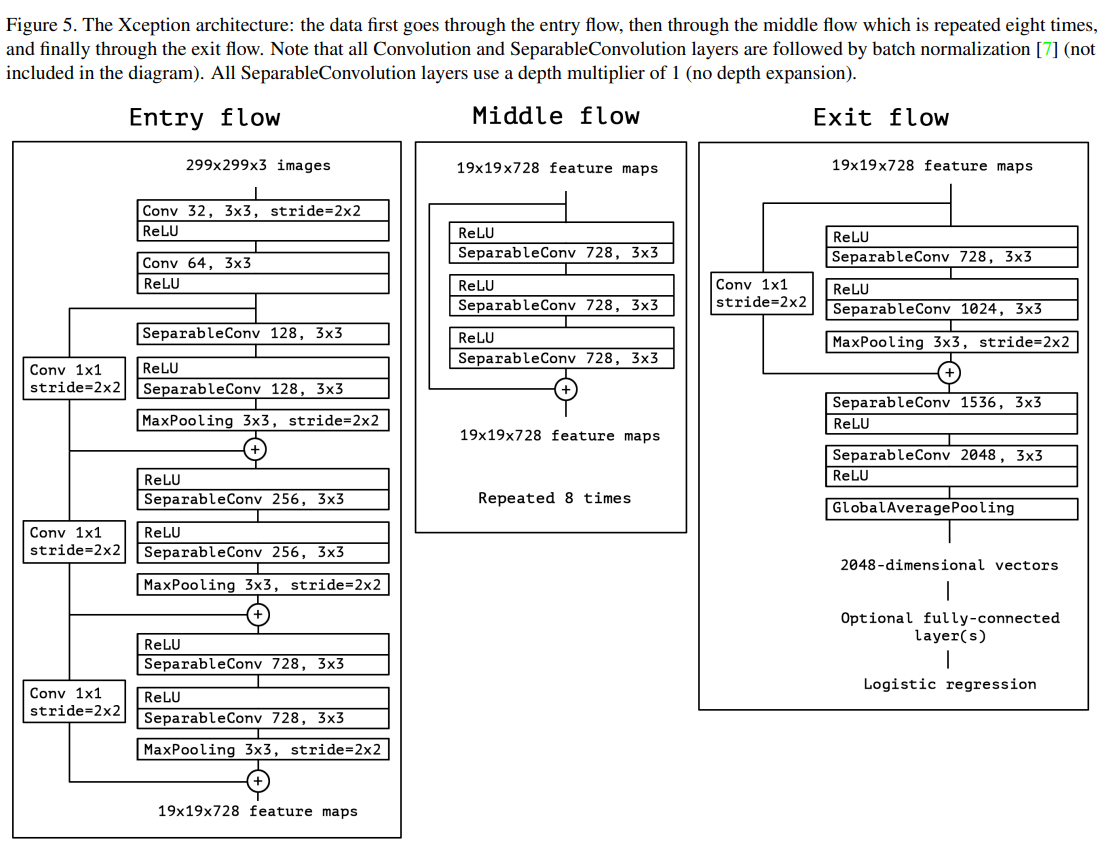
*Reference*:
- [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357.pdf)

#### Create Model Architecture

In [ ]:
params = {
          'RANDOM_STATE': seed,
          'TRAINABLE': False,
          'DENSE_ACTIVATION':'relu',
          'DROPOUT_RATE':0.3,
          'LEARNING_RATE':1e-4,
          'LEARNING_RATE_REDUCE':True,
          'CHECKPOINT':True,
          'EPOCHS':50,
}

Load pre-trained model

- [Xception](https://keras.io/api/applications/xception/)

In [ ]:
input_tensor = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# load pre-trained model and remove top classifier head
base_model = Xception(weights='imagenet', 
                      include_top=False, 
                      input_tensor = input_tensor
                      )

x = base_model.output

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
# We 'freeze' all layers except for the last block of the ResNet50.
for layer in base_model.layers:
    layer.trainable = params['TRAINABLE']

In [ ]:
# un-freeze the BatchNorm layers
for layer in base_model.layers:
  if "BatchNormalization" in layer.__class__.__name__:
      layer.trainable = True

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv1_bn - True
3 block1_conv1_act - False
4 block1_conv2 - False
5 block1_conv2_bn - True
6 block1_conv2_act - False
7 block2_sepconv1 - False
8 block2_sepconv1_bn - True
9 block2_sepconv2_act - False
10 block2_sepconv2 - False
11 block2_sepconv2_bn - True
12 conv2d - False
13 block2_pool - False
14 batch_normalization - True
15 add - False
16 block3_sepconv1_act - False
17 block3_sepconv1 - False
18 block3_sepconv1_bn - True
19 block3_sepconv2_act - False
20 block3_sepconv2 - False
21 block3_sepconv2_bn - True
22 conv2d_1 - False
23 block3_pool - False
24 batch_normalization_1 - True
25 add_1 - False
26 block4_sepconv1_act - False
27 block4_sepconv1 - False
28 block4_sepconv1_bn - True
29 block4_sepconv2_act - False
30 block4_sepconv2 - False
31 block4_sepconv2_bn - True
32 conv2d_2 - False
33 block4_pool - False
34 batch_normalization_2 - True
35 add_2 - False
36 block5_sepconv1_act - False
37 block5_sepconv1 - False
38 block5_sepcon

In [ ]:
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation=params['DENSE_ACTIVATION'])(x) 
x = Dropout(rate=params['DROPOUT_RATE'])(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=input_tensor, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

#### Compile Model

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=params['LEARNING_RATE']) 
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"]
              )

#### Train Model

In [ ]:
# early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=7, 
    verbose=1
)

In [ ]:
# check point - save best model
model_name = 'xception'
model_type = 'feat-extract'
parent_folder = '/content/gdrive/MyDrive/deep_learning/model'

assert os.path.exists(parent_folder), "Error: directory does not exist"
model_fpath = '/content/gdrive/MyDrive/deep_learning/model/'+ model_name +'_'+ model_type +'_'+TIMESTAMP+'.hdf5'
print(model_fpath)

/content/gdrive/MyDrive/deep_learning/model/xception_feat-extract_20230321-040550.hdf5


In [ ]:
check_point = ModelCheckpoint(filepath=model_fpath,
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              save_weights_only=False
                              )

In [ ]:
# Learning Rate Annealer - Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
                               factor=.5, 
                               patience=3, 
                               min_lr=1e-5, 
                               verbose = 1)

In [ ]:
callbacks = [early_stopping]

if params['CHECKPOINT']:
  callbacks.append(check_point)
if params['LEARNING_RATE_REDUCE']:
  callbacks.append(lr_reducer)

callbacks

In [ ]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = params['EPOCHS'],
    callbacks = callbacks
)

Epoch 1/50
808/808 [==============================] - 275s 313ms/step - loss: 1.1857 - accuracy: 0.6251 - val_loss: 0.6860 - val_accuracy: 0.7691 - lr: 1.0000e-04
Epoch 2/50
808/808 [==============================] - 255s 316ms/step - loss: 0.6420 - accuracy: 0.7869 - val_loss: 0.4882 - val_accuracy: 0.8287 - lr: 1.0000e-04
Epoch 3/50
808/808 [==============================] - 257s 317ms/step - loss: 0.5020 - accuracy: 0.8317 - val_loss: 0.4088 - val_accuracy: 0.8515 - lr: 1.0000e-04
Epoch 4/50
808/808 [==============================] - 255s 316ms/step - loss: 0.4154 - accuracy: 0.8608 - val_loss: 0.3330 - val_accuracy: 0.8826 - lr: 1.0000e-04
Epoch 5/50
808/808 [==============================] - 255s 316ms/step - loss: 0.3529 - accuracy: 0.8792 - val_loss: 0.2926 - val_accuracy: 0.8940 - lr: 1.0000e-04
Epoch 6/50
808/808 [==============================] - 255s 315ms/step - loss: 0.3164 - accuracy: 0.8909 - val_loss: 0.2640 - val_accuracy: 0.9015 - lr: 1.0000e-04
Epoch 7/50
808/808 [==

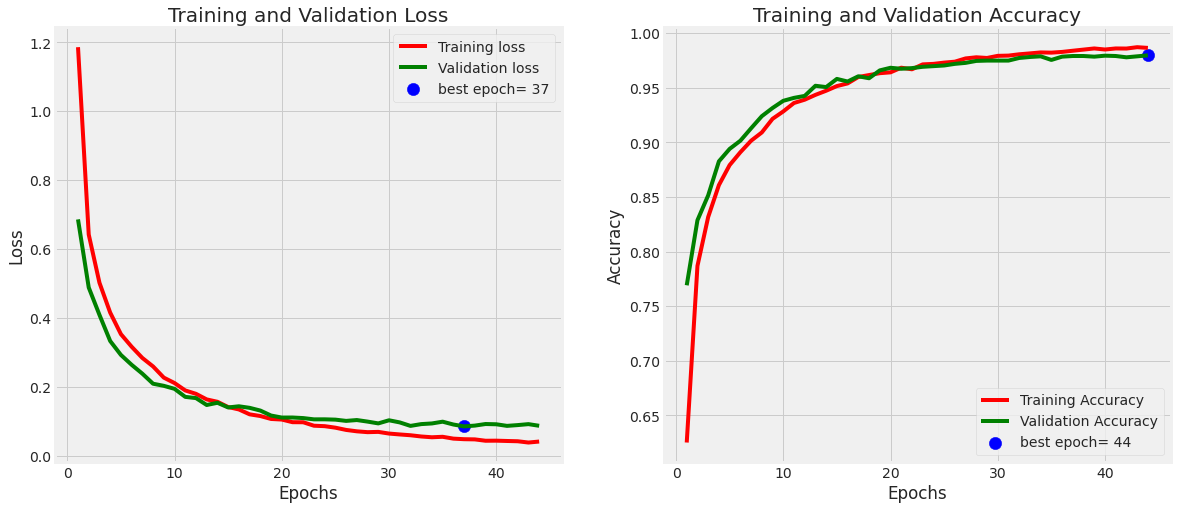

In [ ]:
plot_training(history)

In [ ]:
#load the best model
model.load_weights(model_fpath)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 5s 43ms/step - loss: 0.0754 - accuracy: 0.9829
test loss: 0.07537971436977386 and test accuracy: 0.9829239249229431


In [ ]:
train_loss, train_accuracy = model.evaluate(train_ds)
valid_loss, valid_accuracy = model.evaluate(valid_ds)

print("training loss: {} and training accuracy: {}".format(train_loss, train_accuracy))
print("validation loss: {} and validation accuracy: {}".format(valid_loss, valid_accuracy))

105/105 [==============================] - 5s 40ms/step - loss: 0.0852 - accuracy: 0.9790
training loss: 0.018276795744895935 and training accuracy: 0.994697093963623
validation loss: 0.0851939395070076 and validation accuracy: 0.9790356159210205


In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 1s 740ms/step


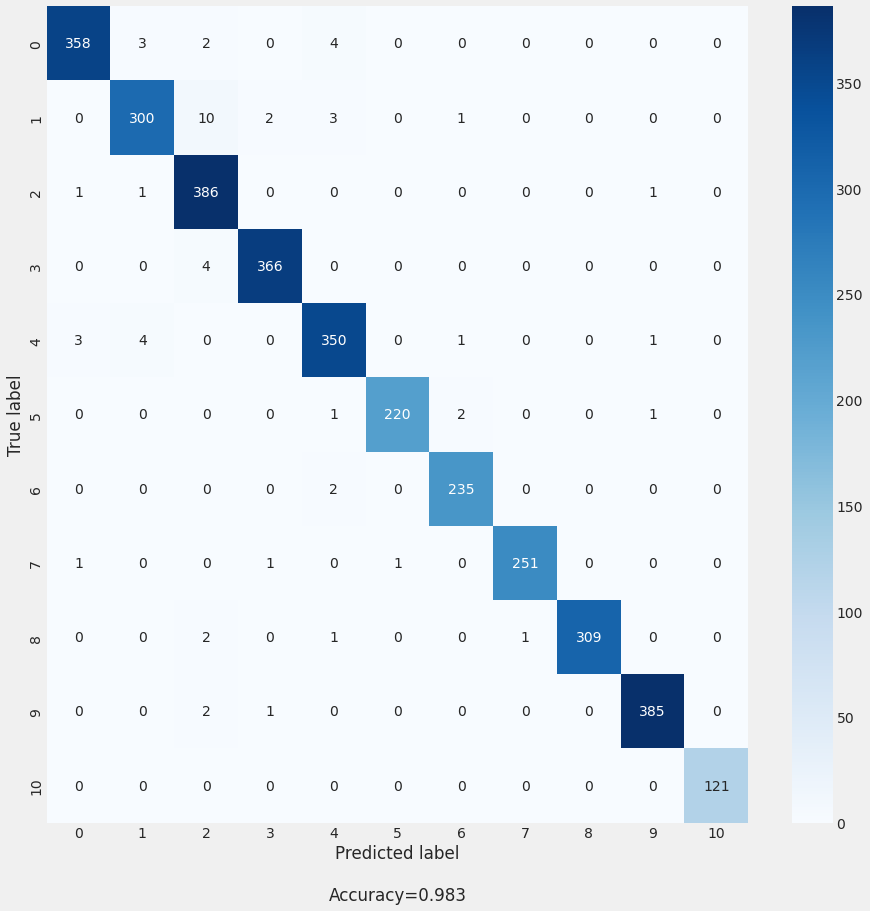

In [ ]:
cf = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf, CLASS_NAMES ,figsize=(14,14))

## 5. Fine-Tuning Pretrained Model

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from Xception.

*Reference*:
- [Usage examples for image classification models](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

Load Saved Model From `h5` file

In [ ]:
from keras.models import load_model
model = load_model(model_fpath)

parameters for fine-tuning

In [ ]:
params_ft = {
          'LEARNING_RATE_FT':1e-5,
          'LEARNING_RATE_REDUCE_FT':True,
          'CHECKPOINT_FT':True,
          'EPOCHS_FT':20,
}

Unfreeze top blocks

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
# unfreeze the pretrained model
base_model.trainable = True

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - True
1 block1_conv1 - True
2 block1_conv1_bn - True
3 block1_conv1_act - True
4 block1_conv2 - True
5 block1_conv2_bn - True
6 block1_conv2_act - True
7 block2_sepconv1 - True
8 block2_sepconv1_bn - True
9 block2_sepconv2_act - True
10 block2_sepconv2 - True
11 block2_sepconv2_bn - True
12 conv2d - True
13 block2_pool - True
14 batch_normalization - True
15 add - True
16 block3_sepconv1_act - True
17 block3_sepconv1 - True
18 block3_sepconv1_bn - True
19 block3_sepconv2_act - True
20 block3_sepconv2 - True
21 block3_sepconv2_bn - True
22 conv2d_1 - True
23 block3_pool - True
24 batch_normalization_1 - True
25 add_1 - True
26 block4_sepconv1_act - True
27 block4_sepconv1 - True
28 block4_sepconv1_bn - True
29 block4_sepconv2_act - True
30 block4_sepconv2 - True
31 block4_sepconv2_bn - True
32 conv2d_2 - True
33 block4_pool - True
34 batch_normalization_2 - True
35 add_2 - True
36 block5_sepconv1_act - True
37 block5_sepconv1 - True
38 block5_sepconv1_bn - True
39 block5_sepc

We need to recompile the model for these modifications to take effect. For fine-tuning, we will use a low learning rate. 

In [ ]:
optimizer_ft = keras.optimizers.Adam(learning_rate=params_ft['LEARNING_RATE_FT'])
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimizer_ft,
              loss=loss,
              metrics=["accuracy"]
              )

Train Model

In [ ]:
# early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=7, 
    verbose=1
)

In [ ]:
# check point - save best model
model_name = 'xception'
model_type = 'fine-tune'
parent_folder = '/content/gdrive/MyDrive/deep_learning/model'

assert os.path.exists(parent_folder), "Error: directory does not exist"
model_fpath_ft = parent_folder +'/'+ model_name +'_'+ model_type +'_'+TIMESTAMP+'.hdf5'
print(model_fpath_ft)

/content/gdrive/MyDrive/deep_learning/model/xception_fine-tune_20230321-040550.hdf5


In [ ]:
check_point_ft = ModelCheckpoint(filepath=model_fpath_ft,
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              save_weights_only=False
                              )

In [ ]:
# Learning Rate Annealer - Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
lr_reducer_ft = ReduceLROnPlateau(monitor='val_loss', 
                               factor=.2, 
                               patience=3, 
                               min_lr=1e-6, 
                               verbose = 1)

In [ ]:
callbacks_ft = [early_stopping]

if params_ft['CHECKPOINT_FT']:
  callbacks_ft.append(check_point_ft)
if params_ft['LEARNING_RATE_REDUCE_FT']:
  callbacks_ft.append(lr_reducer_ft)

callbacks_ft

In [ ]:
history_ft = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = params_ft['EPOCHS_FT'],
    callbacks = callbacks_ft
)

Epoch 1/20
808/808 [==============================] - 269s 315ms/step - loss: 0.0456 - accuracy: 0.9853 - val_loss: 0.0885 - val_accuracy: 0.9787 - lr: 1.0000e-05
Epoch 2/20
808/808 [==============================] - 259s 320ms/step - loss: 0.0432 - accuracy: 0.9860 - val_loss: 0.0859 - val_accuracy: 0.9793 - lr: 1.0000e-05
Epoch 3/20
808/808 [==============================] - 256s 316ms/step - loss: 0.0438 - accuracy: 0.9857 - val_loss: 0.0870 - val_accuracy: 0.9790 - lr: 1.0000e-05
Epoch 4/20
808/808 [==============================] - 258s 319ms/step - loss: 0.0414 - accuracy: 0.9876 - val_loss: 0.0844 - val_accuracy: 0.9799 - lr: 1.0000e-05
Epoch 5/20
808/808 [==============================] - 257s 318ms/step - loss: 0.0424 - accuracy: 0.9867 - val_loss: 0.0826 - val_accuracy: 0.9781 - lr: 1.0000e-05
Epoch 6/20
808/808 [==============================] - 256s 316ms/step - loss: 0.0421 - accuracy: 0.9868 - val_loss: 0.0838 - val_accuracy: 0.9793 - lr: 1.0000e-05
Epoch 7/20
808/808 [==

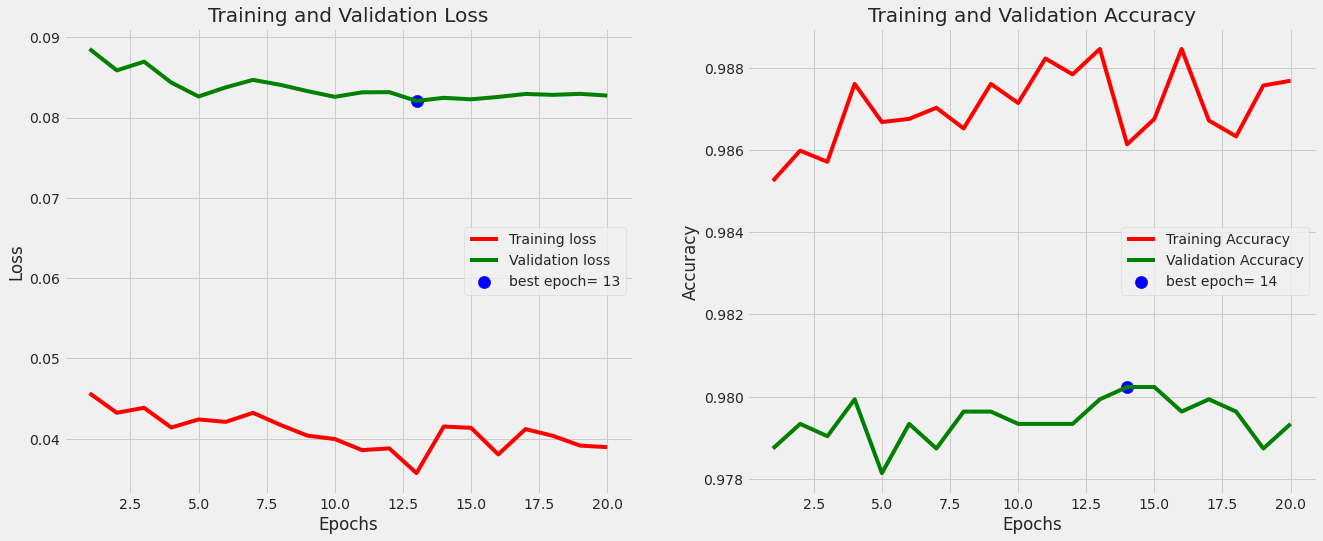

In [ ]:
plot_training(history_ft)

<Figure size 1440x576 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

(0.0, 0.125)

<Axes: >

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

(0.965, 0.99)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

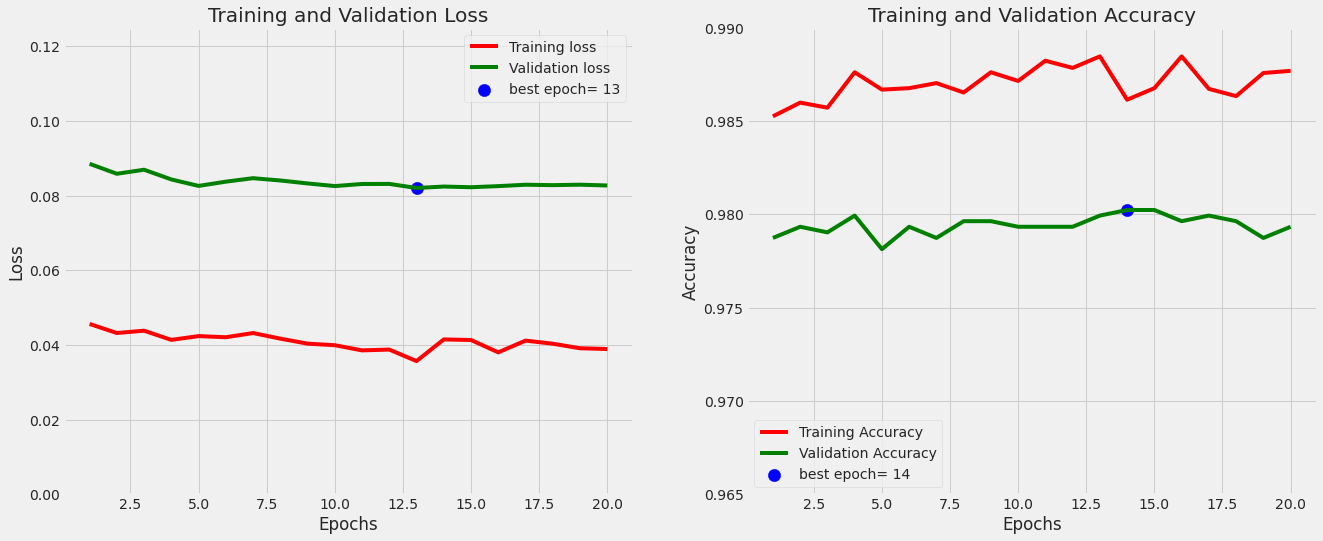

In [ ]:
tr_acc = history_ft.history['accuracy']
tr_loss = history_ft.history['loss']
val_acc = history_ft.history['val_accuracy']
val_loss = history_ft.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
  
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.125)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.965, 0.99)
plt.legend()
plt.tight_layout
plt.show()

Performance Evaluation

In [ ]:
#load the best model
model.load_weights(model_fpath_ft)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 4s 40ms/step - loss: 0.0716 - accuracy: 0.9832
test loss: 0.07163597643375397 and test accuracy: 0.9832234978675842


In [ ]:
train_loss, train_accuracy = model.evaluate(train_ds)
valid_loss, valid_accuracy = model.evaluate(valid_ds)

print("training loss: {} and training accuracy: {}".format(train_loss, train_accuracy))
print("validation loss: {} and validation accuracy: {}".format(valid_loss, valid_accuracy))

105/105 [==============================] - 5s 40ms/step - loss: 0.0821 - accuracy: 0.9799
training loss: 0.015177411958575249 and training accuracy: 0.9962453842163086
validation loss: 0.08206349611282349 and validation accuracy: 0.9799340963363647


In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 1s 742ms/step


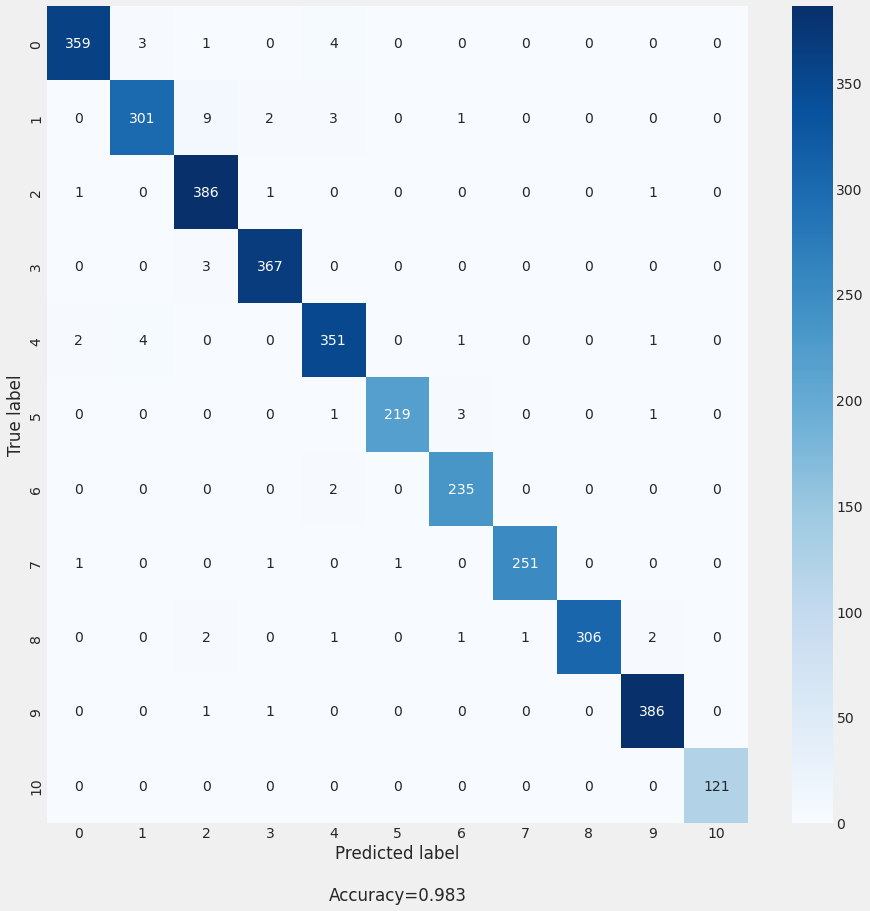

In [ ]:
cf = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf, CLASS_NAMES ,figsize=(14,14))